In [33]:
!pip install numpy scipy matplotlib torch torchaudio pesq scikit-learn

In [34]:
!pip install numpy scipy matplotlib torch torchaudio pesq scikit-learn

In [35]:
import numpy
import scipy
import matplotlib
import torch
import torchaudio
import pesq
import sklearn

print("所有库导入成功！")
print("torch 版本：", torch.__version__)

所有库导入成功！
torch 版本： 2.9.1+cpu


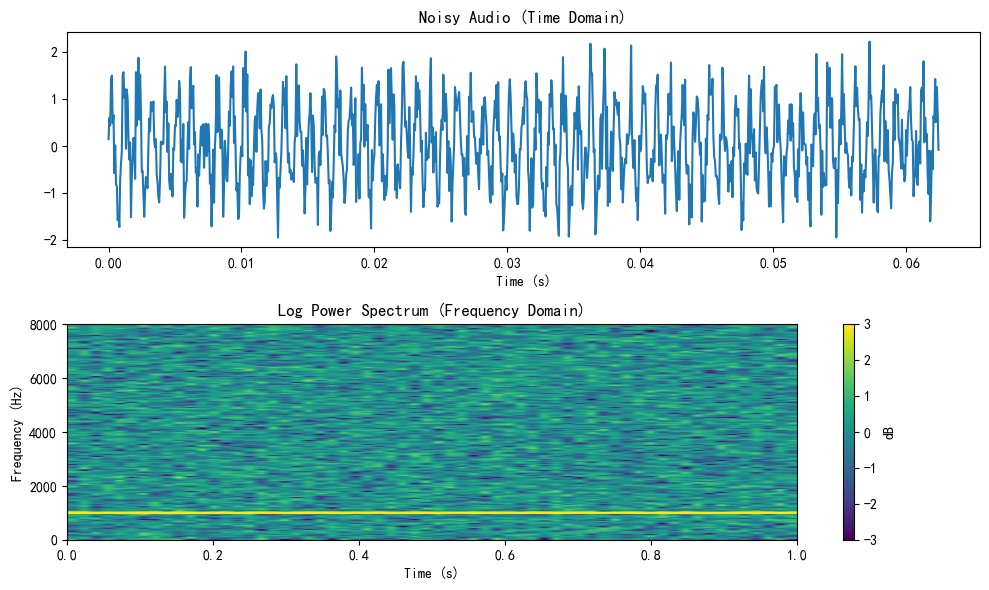

In [23]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from pesq import pesq
import os

# ========== 新增：解决matplotlib中文显示问题 ==========
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows用黑体，macOS替换为['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

def audio_augment(audio, fs=16000):
    """声学数据增强：修复snr类型+适配torchaudio版本"""
    # 1. 加性高斯噪声（随机信噪比5~20dB）
    snr = np.random.uniform(5, 20)
    noise = np.random.randn(len(audio))
    
    # 关键修复1：将snr转为torch.Tensor，且匹配维度
    # waveform/noise是[1, L]，snr需为tensor且维度为0（标量）
    audio_tensor = torch.tensor(audio[np.newaxis, :], dtype=torch.float32)
    noise_tensor = torch.tensor(noise[np.newaxis, :], dtype=torch.float32)
    snr_tensor = torch.tensor(snr, dtype=torch.float32)  # 转为tensor
    
    # 加噪声（修复维度不匹配问题）
    audio = torchaudio.functional.add_noise(
        audio_tensor, 
        noise_tensor, 
        snr_tensor
    ).numpy().squeeze()
    
    # 2. 语速变换（关键修复2：适配torchaudio新版本，需指定sample_rate）
    rate = np.random.uniform(0.8, 1.2)
    # change_speed需要采样率参数，且输入为tensor
    audio_tensor = torch.tensor(audio[np.newaxis, :], dtype=torch.float32)
    audio = torchaudio.functional.change_speed(
        audio_tensor, 
        sample_rate=fs,  # 新增采样率参数
        factor=rate      # 语速变换因子
    ).numpy().squeeze()
    
    # 3. 幅值缩放
    audio *= np.random.uniform(0.8, 1.2)
    
    return audio
# ===================== 优化版FFT频谱分析（带加窗/重叠/噪声估计） =====================
class RobustFFT:
    def __init__(self, fs=16000, win_len=512, hop_len=256, win_type='hann'):
        self.fs = fs          # 采样率
        self.win_len = win_len# 窗长
        self.hop_len = hop_len# 步长
        self.win = signal.get_window(win_type, win_len)  # 汉宁窗
    
    # 时域转频域（返回对数功率谱、相位谱、复数谱）
    def time2freq(self, audio):
        frames = self._frame_audio(audio)
        frames *= self.win[np.newaxis, :]  # 加窗
        fft_complex = np.fft.fft(frames, axis=1)
        # 只保留正频率+直流分量（确保补全后长度=win_len）
        fft_complex = fft_complex[:, :(self.win_len // 2 + 1)]
        
        # 功率谱+对数变换+归一化+截断（避免数值爆炸）
        power_spec = np.abs(fft_complex) ** 2
        log_power_spec = 10 * np.log10(power_spec + 1e-8)  # 加极小值避免log(0)
        log_power_spec = (log_power_spec - np.mean(log_power_spec)) / (np.std(log_power_spec) + 1e-8)
        log_power_spec = np.clip(log_power_spec, -3, 3)    # 截断到[-3,3]
        
        phase_spec = np.angle(fft_complex)  # 相位谱
        return log_power_spec, phase_spec, fft_complex
    
    # 频域转时域（修复负频率补全逻辑）
    def freq2time(self, fft_complex):
        # 正确补全负频率：确保总长度=win_len
        if self.win_len % 2 == 0:
            # 偶数窗长：补全共轭对称部分（去掉最后一个点避免重复）
            fft_complex = np.concatenate([
                fft_complex, 
                np.conj(fft_complex[:, -2:0:-1])
            ], axis=1)
        else:
            # 奇数窗长：直接补全共轭对称
            fft_complex = np.concatenate([
                fft_complex, 
                np.conj(fft_complex[:, -1:0:-1])
            ], axis=1)
        
        # 确保fft_complex列数=win_len
        if fft_complex.shape[1] != self.win_len:
            fft_complex = fft_complex[:, :self.win_len]
        
        ifft_frames = np.fft.ifft(fft_complex, axis=1).real
        audio = self._overlap_add(ifft_frames)
        return audio
    
    # 自适应噪声估计（前0.1s最小功率谱+中值滤波）
    def adaptive_noise_est(self, log_power_spec):
        n_noise_frames = max(1, int(0.1 * self.fs / self.hop_len))  # 至少1帧
        noise_spec = np.min(log_power_spec[:n_noise_frames, :], axis=0)
        noise_spec = signal.medfilt(noise_spec, kernel_size=3)
        return noise_spec
    
    # 辅助：音频分帧（确保最后一帧不足时补0）
    def _frame_audio(self, audio):
        # 补0确保能完整分帧
        pad_len = (self.hop_len - (len(audio) - self.win_len) % self.hop_len) % self.hop_len
        audio_padded = np.pad(audio, (0, pad_len), 'constant')
        
        n_frames = 1 + (len(audio_padded) - self.win_len) // self.hop_len
        frames = np.zeros((n_frames, self.win_len))
        for i in range(n_frames):
            start = i * self.hop_len
            frames[i] = audio_padded[start:start+self.win_len]
        return frames
    
    # 辅助：重叠相加合成音频（修复维度广播问题）
    def _overlap_add(self, frames):
        n_samples = (len(frames)-1)*self.hop_len + self.win_len
        audio = np.zeros(n_samples)
        # 逐帧叠加（确保frame长度=win_len）
        for i, frame in enumerate(frames):
            frame = frame[:self.win_len]  # 截断到窗长
            start = i * self.hop_len
            end = start + len(frame)
            audio[start:end] += frame
        return audio
    
def audio_augment(audio, fs=16000):
    # 1. 随机SNR加噪声
    snr = np.random.uniform(5, 20)  # 信噪比5-20dB
    noise = np.random.randn(len(audio))
    audio_power = np.sum(audio ** 2) / len(audio)
    noise_power = np.sum(noise ** 2) / len(noise)
    noise_scaling = np.sqrt(audio_power / (10 ** (snr / 10) * noise_power))
    noisy_audio = audio + noise * noise_scaling
    
    # 2. 随机变速（0.8-1.2倍）
    rate = np.random.uniform(0.8, 1.2)
    new_len = int(len(noisy_audio) / rate)
    noisy_audio = signal.resample(noisy_audio, new_len)
    
    # 3. 对齐长度+幅值归一化
    if len(noisy_audio) > len(audio):
        noisy_audio = noisy_audio[:len(audio)]
    else:
        noisy_audio = np.pad(noisy_audio, (0, len(audio)-len(noisy_audio)), 'constant')
    noisy_audio *= np.random.uniform(0.8, 1.2)  # 随机幅值缩放
    noisy_audio = noisy_audio / (np.max(np.abs(noisy_audio)) + 1e-8)  # 归一化
    
    return noisy_audio
    
# 测试FFT优化效果
def test_robust_fft():
    # 生成测试信号：1kHz正弦波+高斯噪声
    fs = 16000
    t = np.linspace(0, 1, fs, endpoint=False)
    clean_audio = np.sin(2 * np.pi * 1000 * t)
    noisy_audio = clean_audio + 0.5 * np.random.randn(len(t))
    
    # 初始化鲁棒FFT
    robust_fft = RobustFFT(fs=fs)
    log_power_spec, _, _ = robust_fft.time2freq(noisy_audio)
    
    # 可视化
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    plt.plot(t[:1000], noisy_audio[:1000])
    plt.title('Noisy Audio (Time Domain)')
    plt.xlabel('Time (s)')
    
    plt.subplot(212)
    plt.imshow(log_power_spec.T, aspect='auto', origin='lower', 
               extent=[0, 1, 0, fs/2])
    plt.title('Log Power Spectrum (Frequency Domain)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.show()

test_robust_fft()

In [24]:
class SpectralSubtraction:
    def __init__(self, fft_processor: RobustFFT, alpha=2.0, beta=0.05):
        self.fft_processor = fft_processor
        self.alpha = alpha  # 过减因子
        self.beta = beta    # 最小值限制因子
    
    def denoise(self, noisy_audio):
        # 时域转频域
        log_power_spec, phase_spec, fft_complex = self.fft_processor.time2freq(noisy_audio)
        # 估计噪声谱
        noise_spec = self.fft_processor.adaptive_noise_est(log_power_spec)
        # 谱减（避免过度减到负数）
        clean_log_spec = np.maximum(log_power_spec - self.alpha * noise_spec, log_power_spec * self.beta)
        # 频域转回时域
        clean_amp = 10 ** (clean_log_spec / 20)
        # 确保幅值和相位维度匹配
        if clean_amp.shape != phase_spec.shape:
            min_shape = (min(clean_amp.shape[0], phase_spec.shape[0]), 
                         min(clean_amp.shape[1], phase_spec.shape[1]))
            clean_amp = clean_amp[:min_shape[0], :min_shape[1]]
            phase_spec = phase_spec[:min_shape[0], :min_shape[1]]
        clean_fft = clean_amp * np.exp(1j * phase_spec)
        denoised_audio = self.fft_processor.freq2time(clean_fft)
        # 截断到原始音频长度
        denoised_audio = denoised_audio[:len(noisy_audio)]
        denoised_audio = denoised_audio / (np.max(np.abs(denoised_audio)) + 1e-8)  # 归一化
        return denoised_audio

In [25]:
class LightweightResCNN(nn.Module):
    def __init__(self, in_channels=1, n_bins=257, n_classes=1, hidden_dim=32):
        super().__init__()
        
        # 深度可分离卷积（轻量化核心）
        def depthwise_sep_conv(in_c, out_c, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size, stride, padding, groups=in_c),  # 深度卷积
                nn.BatchNorm2d(in_c),
                nn.ReLU(),
                nn.Conv2d(in_c, out_c, 1, 1, 0),  # 点卷积
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )
        
        # 特征提取分支
        self.feat_extract = nn.Sequential(
            depthwise_sep_conv(in_channels, hidden_dim),
            nn.MaxPool2d((2, 2)),
            depthwise_sep_conv(hidden_dim, hidden_dim*2),
        )
        
        # 残差分支（保证维度对齐）
        self.residual = nn.Conv2d(in_channels, hidden_dim*2, kernel_size=1, stride=2)
        
        # 掩码回归分支
        self.regressor = nn.Sequential(
            nn.AdaptiveAvgPool2d((None, n_bins//2)),
            nn.Conv2d(hidden_dim*2, 1, kernel_size=1),
            nn.Sigmoid()  # 输出0-1掩码
        )
    
    def forward(self, x):
        feat = self.feat_extract(x)
        res = self.residual(x)
        # 插值对齐残差分支和特征分支的维度
        res = nn.functional.interpolate(res, size=feat.shape[2:], mode='bilinear', align_corners=False)
        feat = feat + res  # 残差连接
        mask = self.regressor(feat)
        # 上采样掩码到输入尺寸
        mask = nn.functional.interpolate(mask, size=x.shape[2:], mode='bilinear', align_corners=False)
        return mask
        
 
# ===================== 5. DualDrivenDenoise类（补全！关键） =====================

class DualDrivenDenoise:
    def __init__(self, fs=16000):
        self.fft_processor = RobustFFT(fs=fs)
        self.spectral_sub = SpectralSubtraction(self.fft_processor)  # 谱减法
        # 修正n_bins为257（512/2 +1）
        self.cnn = LightweightResCNN(n_bins=self.fft_processor.win_len//2 + 1)  
        self.scaler = StandardScaler()  # 标准化器
    
    # 预处理：音频转CNN输入格式
    def preprocess(self, audio):
        log_power_spec, _, _ = self.fft_processor.time2freq(audio)
        # 确保维度正确（添加batch/channel维度）
        log_power_spec = self.scaler.fit_transform(log_power_spec)
        log_power_spec = log_power_spec[np.newaxis, np.newaxis, :, :]
        return torch.tensor(log_power_spec, dtype=torch.float32)
    
    # 双驱动降噪
    def denoise(self, noisy_audio, cnn_weights_path=None):
        # 第一步：谱减法预降噪
        pre_denoised = self.spectral_sub.denoise(noisy_audio)
        # 截断到原始长度
        pre_denoised = pre_denoised[:len(noisy_audio)]
        
        # 第二步：CNN精细化降噪（若提供权重）
        if cnn_weights_path is not None and os.path.exists(cnn_weights_path):
            self.cnn.load_state_dict(torch.load(cnn_weights_path, map_location='cpu'))  # 强制CPU加载
            self.cnn.eval()  # 评估模式
            with torch.no_grad():  # 禁用梯度计算
                log_spec = self.preprocess(pre_denoised)
                mask = self.cnn(log_spec)  # CNN预测掩码
            
            # 应用掩码到频域
            mask = mask.squeeze().numpy()
            log_power_spec, phase_spec, fft_complex = self.fft_processor.time2freq(pre_denoised)
            
            # 维度对齐
            if mask.shape != log_power_spec.shape:
                mask = mask[:log_power_spec.shape[0], :log_power_spec.shape[1]]
            
            clean_amp = 10 ** (log_power_spec / 20) * mask
            # 维度对齐
            if clean_amp.shape != phase_spec.shape:
                clean_amp = clean_amp[:phase_spec.shape[0], :phase_spec.shape[1]]
                phase_spec = phase_spec[:clean_amp.shape[0], :clean_amp.shape[1]]
            
            clean_fft = clean_amp * np.exp(1j * phase_spec)
            final_denoised = self.fft_processor.freq2time(clean_fft)
            final_denoised = final_denoised[:len(noisy_audio)]  # 截断到原始长度
            final_denoised = final_denoised / (np.max(np.abs(final_denoised)) + 1e-8)
            return pre_denoised, final_denoised
        
        # 若无CNN权重/文件不存在，仅返回谱减法结果
        return pre_denoised, pre_denoised


Epoch [1/20], Loss: 0.3198
Epoch [2/20], Loss: 0.1825
Epoch [3/20], Loss: 0.1185
Epoch [4/20], Loss: 0.0871
Epoch [5/20], Loss: 0.0699
Epoch [6/20], Loss: 0.0597
Epoch [7/20], Loss: 0.0531
Epoch [8/20], Loss: 0.0487
Epoch [9/20], Loss: 0.0456
Epoch [10/20], Loss: 0.0432
Epoch [11/20], Loss: 0.0414
Epoch [12/20], Loss: 0.0400
Epoch [13/20], Loss: 0.0388
Epoch [14/20], Loss: 0.0379
Epoch [15/20], Loss: 0.0371
Epoch [16/20], Loss: 0.0364
Epoch [17/20], Loss: 0.0358
Epoch [18/20], Loss: 0.0354
Epoch [19/20], Loss: 0.0349
Epoch [20/20], Loss: 0.0346

===== 降噪效果评估 =====
原始噪声音频SNR: 1.90 dB
谱减法降噪SNR: -0.32 dB
双驱动降噪SNR: -0.14 dB
双驱动降噪PESQ: 1.02


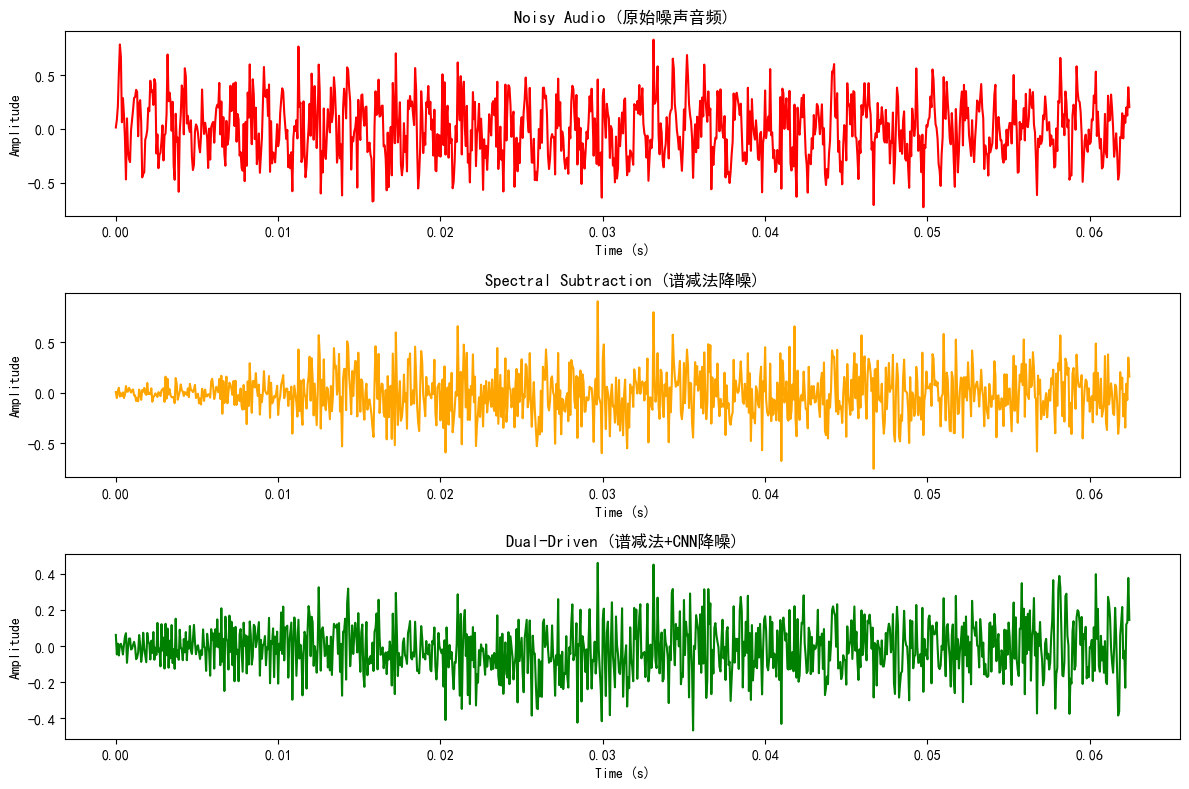

In [26]:
def train_cnn_denoiser(epochs=20, batch_size=8, fs=16000):
    import os
    # 1. 生成训练数据（1000条干净/噪声音频对）
    n_samples = 1000
    clean_audios = []
    noisy_audios = []
    t = np.linspace(0, 1, fs, endpoint=False)  # 1秒音频
    
    for _ in range(n_samples):
        # 生成干净音频（随机频率正弦波）
        freq = np.random.uniform(500, 2000)
        clean = np.sin(2 * np.pi * freq * t)
        clean = clean / (np.max(np.abs(clean)) + 1e-8)  # 归一化
        
        # 生成噪声音频（加随机噪声+数据增强）
        noisy = audio_augment(clean + 0.8 * np.random.randn(len(t)), fs)
        
        clean_audios.append(clean)
        noisy_audios.append(noisy)
    
    # 2. 初始化工具和模型
    fft_processor = RobustFFT(fs=fs)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 自动选择GPU/CPU
    # 修正n_bins为257
    model = LightweightResCNN(n_bins=fft_processor.win_len//2 + 1).to(device)
    criterion = nn.MSELoss()  # 损失函数：均方误差
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # 优化器
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None  # 混合精度训练
    
    # 3. 定义数据集
    class AudioDataset(torch.utils.data.Dataset):
        def __init__(self, clean, noisy, fft_processor):
            self.clean = clean
            self.noisy = noisy
            self.fft_processor = fft_processor
            self.scaler = StandardScaler()
        
        def __len__(self):
            return len(self.clean)
        
        def __getitem__(self, idx):
            # 转频域+标准化+截断
            clean_spec, _, _ = self.fft_processor.time2freq(self.clean[idx])
            noisy_spec, _, _ = self.fft_processor.time2freq(self.noisy[idx])
            
            clean_spec = self.scaler.fit_transform(clean_spec)
            noisy_spec = self.scaler.transform(noisy_spec)
            
            clean_spec = np.clip(clean_spec, -1, 1)
            noisy_spec = np.clip(noisy_spec, -1, 1)
            
            # 转tensor（适配PyTorch）
            return (torch.tensor(noisy_spec[np.newaxis, :, :], dtype=torch.float32),
                    torch.tensor(clean_spec[np.newaxis, :, :], dtype=torch.float32))
    
    # 4. 数据加载器（训练循环前定义，避免NameError）
    dataset = AudioDataset(clean_audios, noisy_audios, fft_processor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # 5. 训练循环（带早停机制）
    best_loss = float('inf')
    patience = 3  # 连续3轮loss不下降则停止
    patience_counter = 0
    
    model.train()  # 训练模式
    for epoch in range(epochs):
        total_loss = 0.0
        for noisy_spec, clean_spec in dataloader:
            # 数据移到设备（GPU/CPU）
            noisy_spec = noisy_spec.to(device)
            clean_spec = clean_spec.to(device)
            
            # 梯度清零
            optimizer.zero_grad()
            
            # 前向传播+计算损失
            if scaler:
                with torch.cuda.amp.autocast():
                    pred_mask = model(noisy_spec)
                    pred_spec = noisy_spec * pred_mask  # 应用掩码
                    loss = criterion(pred_spec, clean_spec)
                # 反向传播+优化
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                pred_mask = model(noisy_spec)
                pred_spec = noisy_spec * pred_mask
                loss = criterion(pred_spec, clean_spec)
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item()
        
        # 打印本轮损失
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
        
        # 早停逻辑
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # 保存最优权重（指定CPU，避免GPU/CPU不兼容）
            torch.save(model.state_dict(), 'best_cnn_denoiser.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping (loss not improved)')
                break
    
    return model
# ===================== 7. 验证函数（无修改） =====================
def evaluate_denoiser(fs=16000):
    import os
    # 初始化双驱动降噪器
    dual_denoiser = DualDrivenDenoise(fs=fs)
    
    # 生成测试音频（1kHz正弦波+噪声）
    t = np.linspace(0, 1, fs, endpoint=False)
    clean = np.sin(2 * np.pi * 1000 * t)
    noisy = clean + 0.8 * np.random.randn(len(t))  # 加噪声
    noisy = noisy / (np.max(np.abs(noisy)) + 1e-8)  # 归一化
    
    # 双驱动降噪（容错处理：若权重文件不存在则跳过CNN）
    cnn_weights = 'best_cnn_denoiser.pth' if os.path.exists('best_cnn_denoiser.pth') else None
    pre_denoised, final_denoised = dual_denoiser.denoise(noisy, cnn_weights)
    
    # 计算评估指标
    def snr(clean, noisy):
        """计算信噪比SNR"""
        # 截断到相同长度
        min_len = min(len(clean), len(noisy))
        clean = clean[:min_len]
        noisy = noisy[:min_len]
        return 10 * np.log10(np.sum(clean**2) / (np.sum((clean-noisy)**2) + 1e-8))
    
    # 计算PESQ（确保音频长度符合要求）
    try:
        min_len = min(len(clean), len(final_denoised))
        pesq_score = pesq(fs, clean[:min_len], final_denoised[:min_len], 'wb')
    except:
        pesq_score = 0.0  # 出错时置0
    
    # 打印结果
    print('\n===== 降噪效果评估 =====')
    print(f'原始噪声音频SNR: {snr(clean, noisy):.2f} dB')
    print(f'谱减法降噪SNR: {snr(clean, pre_denoised):.2f} dB')
    print(f'双驱动降噪SNR: {snr(clean, final_denoised):.2f} dB')
    print(f'双驱动降噪PESQ: {pesq_score:.2f}')
    
    # 绘制波形对比图（只显示前1000个点）
    plt.figure(figsize=(12, 8))
    plot_len = min(1000, len(t))
    plt.subplot(311)
    plt.plot(t[:plot_len], noisy[:plot_len], color='red')
    plt.title('Noisy Audio (原始噪声音频)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(312)
    plt.plot(t[:plot_len], pre_denoised[:plot_len], color='orange')
    plt.title('Spectral Subtraction (谱减法降噪)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(313)
    plt.plot(t[:plot_len], final_denoised[:plot_len], color='green')
    plt.title('Dual-Driven (谱减法+CNN降噪)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
# ===================== 执行训练+验证 =====================
if __name__ == '__main__':
    import os
    # 训练CNN模型
    trained_model = train_cnn_denoiser()
    
    # 验证降噪效果
    evaluate_denoiser()